#### Forecasting Bike Sales Revenue

##### Import library

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error

##### Import dataset and preprocess

In [58]:
df = pd.read_csv('EuropeBikeSales.csv')
df = df[['Date', 'Revenue']]

# Group by Date và tính tổng Revenue
grouped_df = df.groupby('Date').sum().reset_index()

# Chuyển đổi cột 'Date' thành kiểu datetime với định dạng 'dd/mm/yyyy'
grouped_df['Date'] = pd.to_datetime(grouped_df['Date'], format='%d/%m/%Y')

# # Sắp xếp DataFrame theo cột 'Date'
df_sorted = grouped_df.sort_values(by='Date')

# df1 = df_sorted
df = df_sorted.reset_index(drop=True)
temp_data = df.reset_index()
df = df[['Revenue']]

In [59]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [60]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [61]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [62]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [63]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [64]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [65]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0283
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0069
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0063
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0061
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0059
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0068
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0064
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0057
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0064
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0063
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0061
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0065
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0060
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0061
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0055
E

In [66]:
# 10. Dự báo dữ liệu test, val
y_pred=model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


In [67]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [68]:
# 13. Dự báo 30 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))

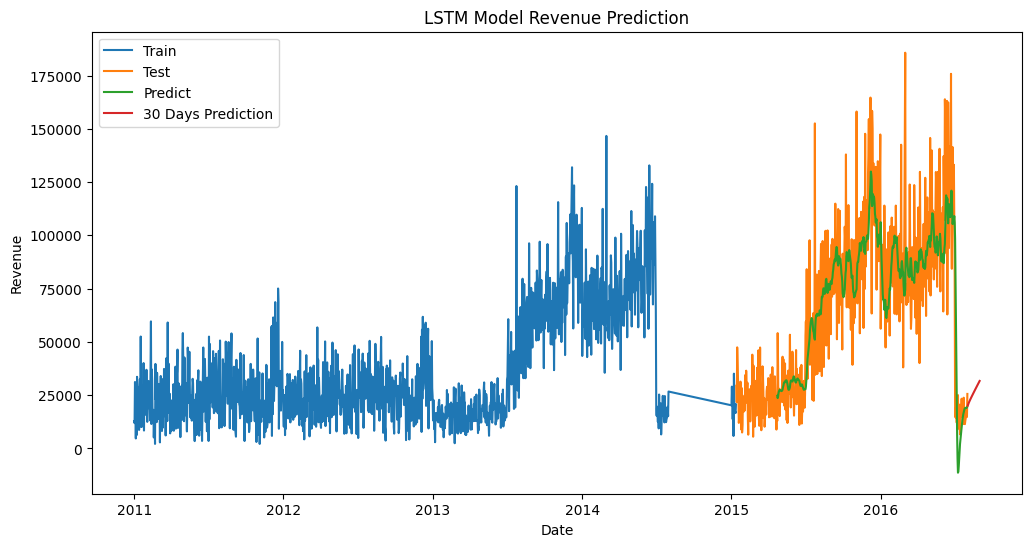

In [69]:
# 14.Vẽ hình
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]
# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model Revenue Prediction')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()

In [70]:
# Calculate accuracy metrics
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 22970.116044951294
Testing MAPE: 30.173507048704195
Testing MAE: 17201.112871104273
